<a id = 'top'></a>
## Maybe one day we'll find an asteroid that will bring life to Mars
(but for now, we'll just look at a random lab spectrum)

Erika Hornecker and Mairead Heiger

- [imports](#imp) and [pleasantries](#style)
- [data](#data)
- [observed spectrum](#sim)
    - [set it up](#set)
    - [plot it](#simplot)
- [specify the model](#stan)
    - [data for stan](#standat)
    - [build](#build)
    - [sample](#stansamp)
        - [estimates](#stanest)
- [plot the results](#results)
    - [best-fit](#fitplot)
    - [diagnostics](#diag)
        - [trace plots](#trace)
        - [autocorrelation](#tau)
        - [effective sample size](#ess)
        - [corner plot](#corner)
        - [energy](#energy)


<a id = 'imp'></a>
## Imports 

[Index](#top)

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from astropy.io import ascii
from astropy.table import Table

import scipy.stats as stats

import arviz as az
import stan

import nest_asyncio

import asteroids_functions as fast

import pickle

In [2]:
nest_asyncio.apply()

<a id = 'data'></a>
## Data

[Index](#top)

In [3]:
linelist = ascii.read("CC_CI1_Features.csv")

In [4]:
linelist

<Table length=9>
                                   Feature                                    ...   mean 
                                    str76                                     ... float64
----------------------------------------------------------------------------- ... -------
                                                      (?) common in CI spect. ...   0.475
                                                 Fe3+ - Fe2+ charge transfers ...   0.725
              Fe2+ crystal field transitions in Fe2+- bearing phyllosilicates ...   0.925
                                                                    magnetite ...   1.005
               Fe2+ crystal field transitions in Fe2+-bearing phyllosilicates ...   1.125
                                                        Serpentines (from OH) ...    1.38
                                             Saponites (from OH, sharp bands) ...   1.405
                                            Saponites (from H2O, sharp bands) ...    1.46
Combination band dude to H-O-H bending plus O-H stretching\n(presence of H2O) ...    1.91

<a id = 'sim'></a>

# Load the real spectrum

[Index](#top)

In [5]:
your_file = 'saponite_norm_T.txt'

In [6]:
spectrum = ascii.read(your_file)
spectrum['col1'] = spectrum['col1'] / 1000

In [7]:
spectrum

<Table length=430>
  col1         col2               col3               col4       
float64      float64            float64            float64      
------- ------------------ ------------------ ------------------
    0.4 1.0443620527697652 0.7638018711709978                1.0
  0.405 1.0387604255860652 0.7528158346733661                1.0
   0.41 1.0297766279058747  0.735196609765092                1.0
  0.415 1.0220452396987314 0.7200336383220457                1.0
   0.42 1.0128334882370613 0.7019673453599757                1.0
  0.425 1.0074007359258625 0.6913125100387147                1.0
   0.43 1.0003041014962957 0.6773944318987707                1.0
  0.435 0.9994942571569267 0.6758061470704628 0.9985344605890577
   0.44  0.995487407598298 0.6679478241139288 0.9869234293657517
  0.445 0.9917628524107337 0.6606431431906622  0.976130429543084
   0.45 0.9911640425318543 0.6594687438654708 0.9743952008805754
  0.455 0.9848960228298765   0.64717576345896 0.9562317606507735
    ...                ...                ...                ...
  2.485 1.0035999550005628 0.6838583334940227                1.0
   2.49 1.0042568968223469 0.6851467424855996                1.0
  2.495 1.0013607561213531 0.6794667665786029                1.0
    2.5 1.0005158563767573 0.6778097303056466                1.0
  2.505 1.0036466814224008 0.6839499743974391                1.0
   2.51  0.999890426661722 0.6765831235625068 0.9996824788569244
  2.515 0.9956270617709408 0.6682217170002968 0.9873281186198138
   2.52 0.9924351610742185 0.6619616899758196 0.9780786426639412
  2.525  0.997633033863165 0.6721558743256062 0.9931410158237375
   2.53 1.0004473272198613 0.6776753293906763                1.0
  2.535  1.000395541804374 0.6775737666757844                1.0
   2.54 0.9999245842150325  0.676650114119899 0.9997814604663402
  2.545  1.005000402536877 0.6866049225193932                1.0

<a id = 'set'></a>

### Properties of the spectrum

[Index](#top)

In [8]:
M = np.max(spectrum['col1'])      # set the size of the wavelength grid in micron
dM = np.diff(spectrum['col1'])[0] # the step in the wavelength grid
x = spectrum['col1']              # this is the wavelength grid
N = len(x)                        # the number of data points we have is related to the grid
ye = 0.01                         # error (noise)


<a id = 'simplot'></a>

### Plot it

[Index](#top)

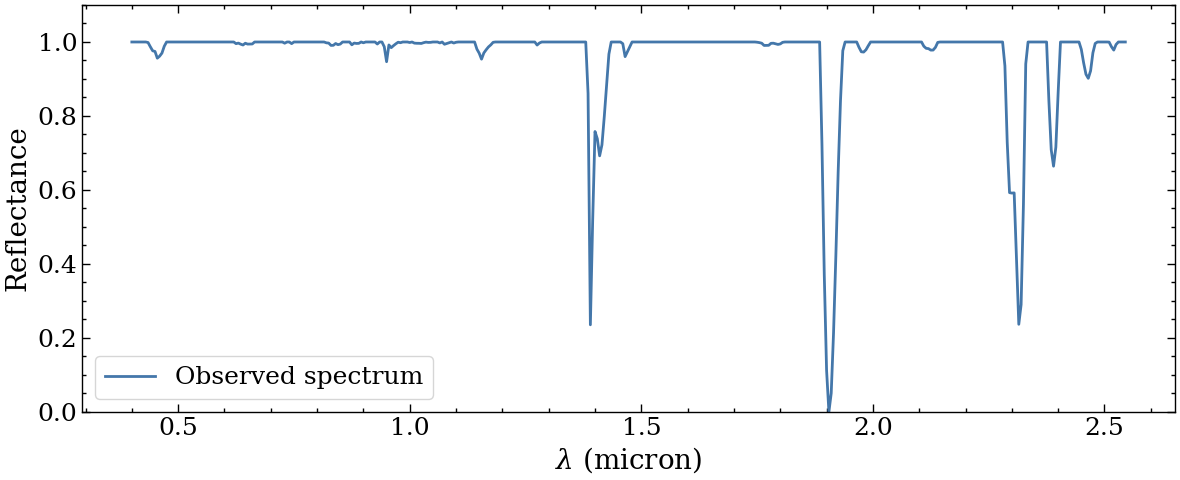

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (12, 5))

# plot the observed spectrum
ax.plot(x, spectrum['col4'], '-', lw = 2)
ax.legend(["Observed spectrum"])

# format
ax.set_xlabel(r"$\lambda$ (micron)")
ax.set_ylabel(r"Reflectance")
ax.set_ylim(0,1.1)

plt.tight_layout()

plt.show()

<a id = 'stan'></a>
## Specify the model

- [Model](#stan)
- [Data](#standat)
- [Build](#build)
- [Sample](#stansamp)

[Index](#top)

In [10]:
# specify the model for stan
stan_code = """ 
functions {
    real G(data real x, real phi, real mu, real sigma){
        return -phi * exp(-(x - mu)^2./(2.*sigma^2.));
    }
}

data {
    int<lower=0> K;                     // number of features (mixture components)
    int<lower=0> N;                     // number of data points (depends on how finely you sample the spectrum)
    vector[N] yo;                       // observations (literally the values of the reflectance at lambda)
    real ye;                            // error on observation
    vector[N] x;                        // wavelength grid
    real del;                           // size of the little box around each mean
    vector[K] mut;                      // means of the known features (sorted)
    vector[K] mut_l;                    // range of the known features (left bound)
    vector[K] mut_r;                    // ^^ (right bound)
}   
   
parameters {   

    // characteristics of the features (the gaussians we want to recover)
    
    real<lower = mut_l[1]-0.01, upper = mut_r[1]+0.01>  common_feats;    // locations of the features 
    real<lower = mut_l[2]-0.01, upper = mut_r[2]+0.01>   fe32_charge;
    real<lower = mut_l[3]-0.01, upper = mut_r[3]+0.01> fe2_crystal_1;
    real<lower = mut_l[4]-0.01, upper = mut_r[4]+0.01>     magnetite;
    real<lower = mut_l[5]-0.01, upper = mut_r[5]+0.01> fe2_crystal_2;
    real<lower = mut_l[6]-0.01, upper = mut_r[6]+0.01>   serpentines;
    real<lower = mut_l[7]-0.01, upper = mut_r[7]+0.01>  oh_saponites;
    real<lower = mut_l[8]-0.01, upper = mut_r[8]+0.01> h2o_saponites;
    real<lower = mut_l[9]-0.01, upper = mut_r[9]+0.01>        hoh_oh;
    
    vector<lower = 0>[K] sigma;                     // width of the feature
                                
    vector<lower = -0.01, upper = 1.5>[K] phi;      // (negative) depth of the feature
                                        
    real epsilon;                                   // continuum level (offset of the entire spectrum from 0 -- like an intercept)
    
}

transformed parameters{
    // the "line" of our linear regression
    vector[K] mus = [common_feats, fe32_charge, fe2_crystal_1, magnetite, fe2_crystal_2, serpentines, oh_saponites, h2o_saponites, hoh_oh]';
    vector[K] ps;                                   // placeholder
    vector[N] yt;                                   // noiseless "true" value, yo = phi*yt + epsilon
    
    // if phi of feature k is non-zero, it's contributing to the observed reflectance, so it's worth constraining its mean, SD
    // otherwise, it doesn't, but the model will still do its best to constrain them
    // so instead we don't include them in the likelihod, and their mean, SD become dependent on the initial guess    
    
    for (n in 1:N){
        for (k in 1:K){
            if (phi[k] > 0.01){
                ps[k] = G(x[n], phi[k], mus[k], sigma[k]);       // the features that are doing things
            }                                                    
            else{
                ps[k] = 0;                                       // the features that don't actually exist                                                           
            }
        }
        yt[n] = sum(ps) + epsilon;
    }

}

model{

    // priors
    
    phi ~ normal(0.5,0.5);                          // height of peak
       
    common_feats   ~ normal(mut[1], del);  // each mean is unique and ordered
    fe32_charge    ~ normal(mut[2], del);
    fe2_crystal_1  ~ normal(mut[3], del);
    magnetite      ~ normal(mut[4], del);
    fe2_crystal_2  ~ normal(mut[5], del);
    serpentines    ~ normal(mut[6], del);
    oh_saponites   ~ normal(mut[7], del);
    h2o_saponites  ~ normal(mut[8], del);
    hoh_oh         ~ normal(mut[9], del);
    
    epsilon ~ normal(1, 1);                         // continuum level

    sigma ~ normal(0.1, 0.05);                      // sigma
    
    
    // likelihood
    
    yo ~ normal(yt, ye);
}
"""




<a id = 'standat'></a>

### Make a dictionary of the data for stan

- [Model](#stan)
- [Data](#standat)
- [Build](#build)
- [Sample](#stansamp)


[Index](#top)

In [11]:
data = {}
data["K"] = 9                        # we have 9 features, although several of them should be 0 here
data["N"] = N                        # and N = M/dM samples on the curve
data["yo"] = spectrum['col4']        # and these are the values of the observed reflectance
data["ye"] = ye                      # with their error
data["x"] = x                        # at these values of lambda
data["del"] = 0.1                    # this is how big the little windowbox prior should be for each mu
data["mut"] = linelist['mean']       # and this is where we think they are
data["mut_l"] = linelist['left']     # ^^
data["mut_r"] = linelist['right']    # ^^


<a id = 'build'></a>

### Build the model

- [Model](#stan)
- [Data](#standat)
- [Build](#build)
- [Sample](#stansamp)

[Index](#top)

In [12]:
fit = stan.build(program_code = stan_code, data = data) # build the model

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_syho537j/model_xpgz4qnv.stan', line 84, column 24: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_syho537j/model_xpgz4qnv.stan', line 54, column 12: A
    control flow statement depends on parameter(s): phi.
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,

<a id = 'stansamp'></a>

### Sample

- [Model](#stan)
- [Data](#standat)
- [Build](#build)
- [Sample](#stansamp)

[Index](#top)

In [13]:
# you can def change the guess to whatever you want as long as it's within the allowed bounds of the data
# so you can't let stan do it because it just puts everything at 0 or something

initial_guess = [{'sigma':np.random.uniform(0,0.1, size = 9), 
                  'phi':np.random.uniform(0,1, size = 9), 
                  'epsilon':1, 
                  'mus':np.array(linelist['mean']), 
                  'yt':spectrum['col4']}, 
                 {'sigma':np.random.uniform(0,0.1, size = 9), 
                  'phi':np.random.uniform(0,1, size = 9), 
                  'epsilon':1, 
                  'mus':np.array(linelist['mean']), 
                  'yt':spectrum['col4']},
                {'sigma':np.random.uniform(0,0.1, size = 9), 
                  'phi':np.random.uniform(0,1, size = 9), 
                  'epsilon':1, 
                  'mus':np.array(linelist['mean']), 
                  'yt':spectrum['col4']}]

In [14]:
draws = fit.sample(num_chains = 3, 
                   num_samples = 1000,
                   init=initial_guess, 
                   num_warmup = 1000, delta = 0.9) # sample (3 chains of 5000 burn-in steps + 5000 sampling steps each)

# this is 1000 + 1000 steps just to make sure it runs through!
# for science runs we did 5000 + 5000 steps

Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  38% (2301/6000)
Sampling:  40% (2401/6000)
Sampling:  42% (2501/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2800/6000)
Sampling:  48% (2900/6000)
Sampling:  50% (3000/6000)
Sampling:  50% (3001/6000)
Sampling:  52% (3101/6000)
Sampling:  53% (3201/6000)
Samp

<a id = 'stanest'></a>

#### Get  estimates of the parameters

- [Model](#stan)
- [Data](#standat)
- [Build](#build)
- [Sample](#stansamp)
    - [Estimates](#stanest)

[Index](#top)

In [15]:
# widths, weights, intercepts, and true values
sigma = np.median(draws['sigma'], axis = 1)
phi = np.median(draws['phi'],axis = 1)
eps = np.median(draws['epsilon'],axis = 1)
yt = np.median(draws['yt'], axis = 1)

# and all the means
common_feats  = np.median(draws["common_feats"])
fe32_charge   = np.median(draws["fe32_charge"])
fe2_crystal_1 = np.median(draws["fe2_crystal_1"])
magnetite     = np.median(draws["magnetite"])
fe2_crystal_2 = np.median(draws["fe2_crystal_2"])
serpentines   = np.median(draws["serpentines"])
oh_saponites  = np.median(draws["oh_saponites"])
h2o_saponites = np.median(draws["h2o_saponites"])
hoh_oh        = np.median(draws["hoh_oh"])

means = [common_feats,fe32_charge,
         fe2_crystal_1,magnetite,
         fe2_crystal_2,serpentines,
         oh_saponites ,h2o_saponites,
         hoh_oh]



<a id = 'results'></a>

## Results

- [best-fit](#fitplot)
- [diagnostics](#diag)


[Index](#top)

<a id = 'fitplot'></a>

### Best-fit

[Index](#top)

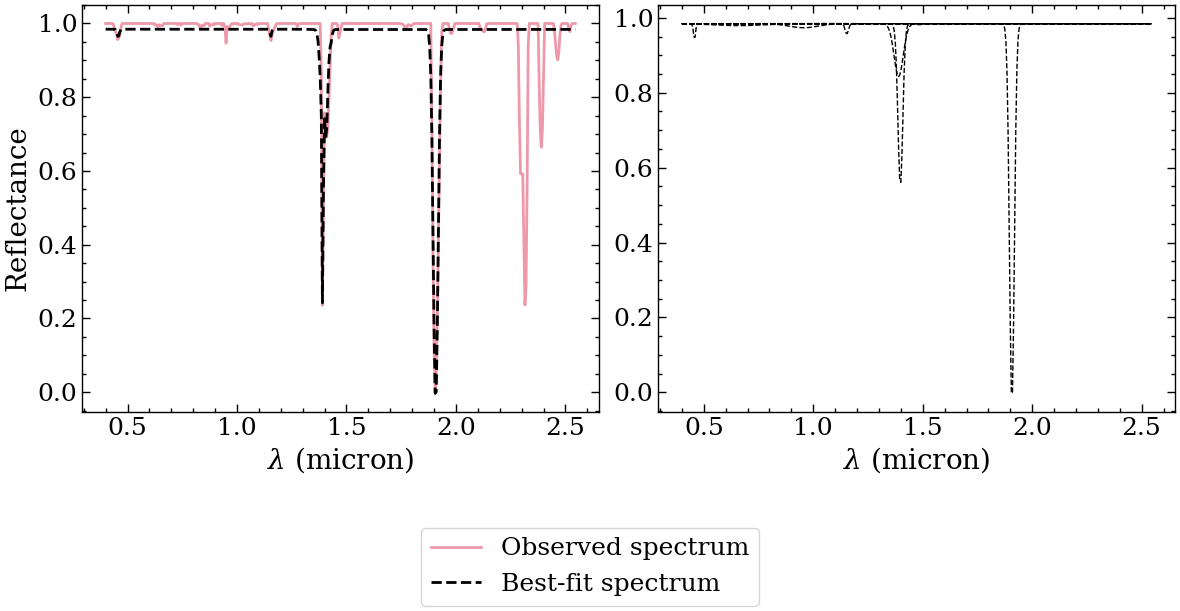

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

# plot the observed spectrum
ax[0].plot(x, spectrum['col4'], '-', color = mc[5], lw = 2, label = 'Observed spectrum')

# plot the best fit spectrum
ax[0].plot(x, yt, 'k--', lw = 2, label = 'Best-fit spectrum')

# plot the best-fit components
f = []
for i,m in zip(range(9),means):
    ax[1].plot(x, -phi[i]*fast.G(x, m, sigma[i]) + eps, 'k--', zorder = 10)
    
    # and the initial guesses
    #ax[1].plot(x, -initial_guess[0]['phi'][i]*fast.G(x, initial_guess[0]['mus'][i], 
    #                                              initial_guess[0]['sigma'][i]) + 1, 'k:', label = ['Initial guess' if i == 0 else '__None'][0])

# format
fig.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.05))
ax[0].set_xlabel(r"$\lambda$ (micron)"); ax[1].set_xlabel(r"$\lambda$ (micron)")
ax[0].set_ylabel(r"Reflectance")


plt.show()

<a id = 'diag'></a>

### Diagnostics 

Does the model converge? Is it well-mixed? Are there a lot of divergent transitions? All of these (and more!) have been problems in other models we tried. These are some of the diagnostics we used.

- [trace plots](#trace)
- [autocorrelation](#tau)
- [effective sample size](#ess)
- [corner plot](#corner)
- [energy](#energy)

[Index](#top)

<a id = 'trace'></a>

#### Trace plot

Since some of the features have $\phi = 0$, we expect their other characteristics ($\mu$, $\sigma$) to behave a little weirdly. Well-behaved chains in $\phi$ for these features are most important.

[Index](#top)

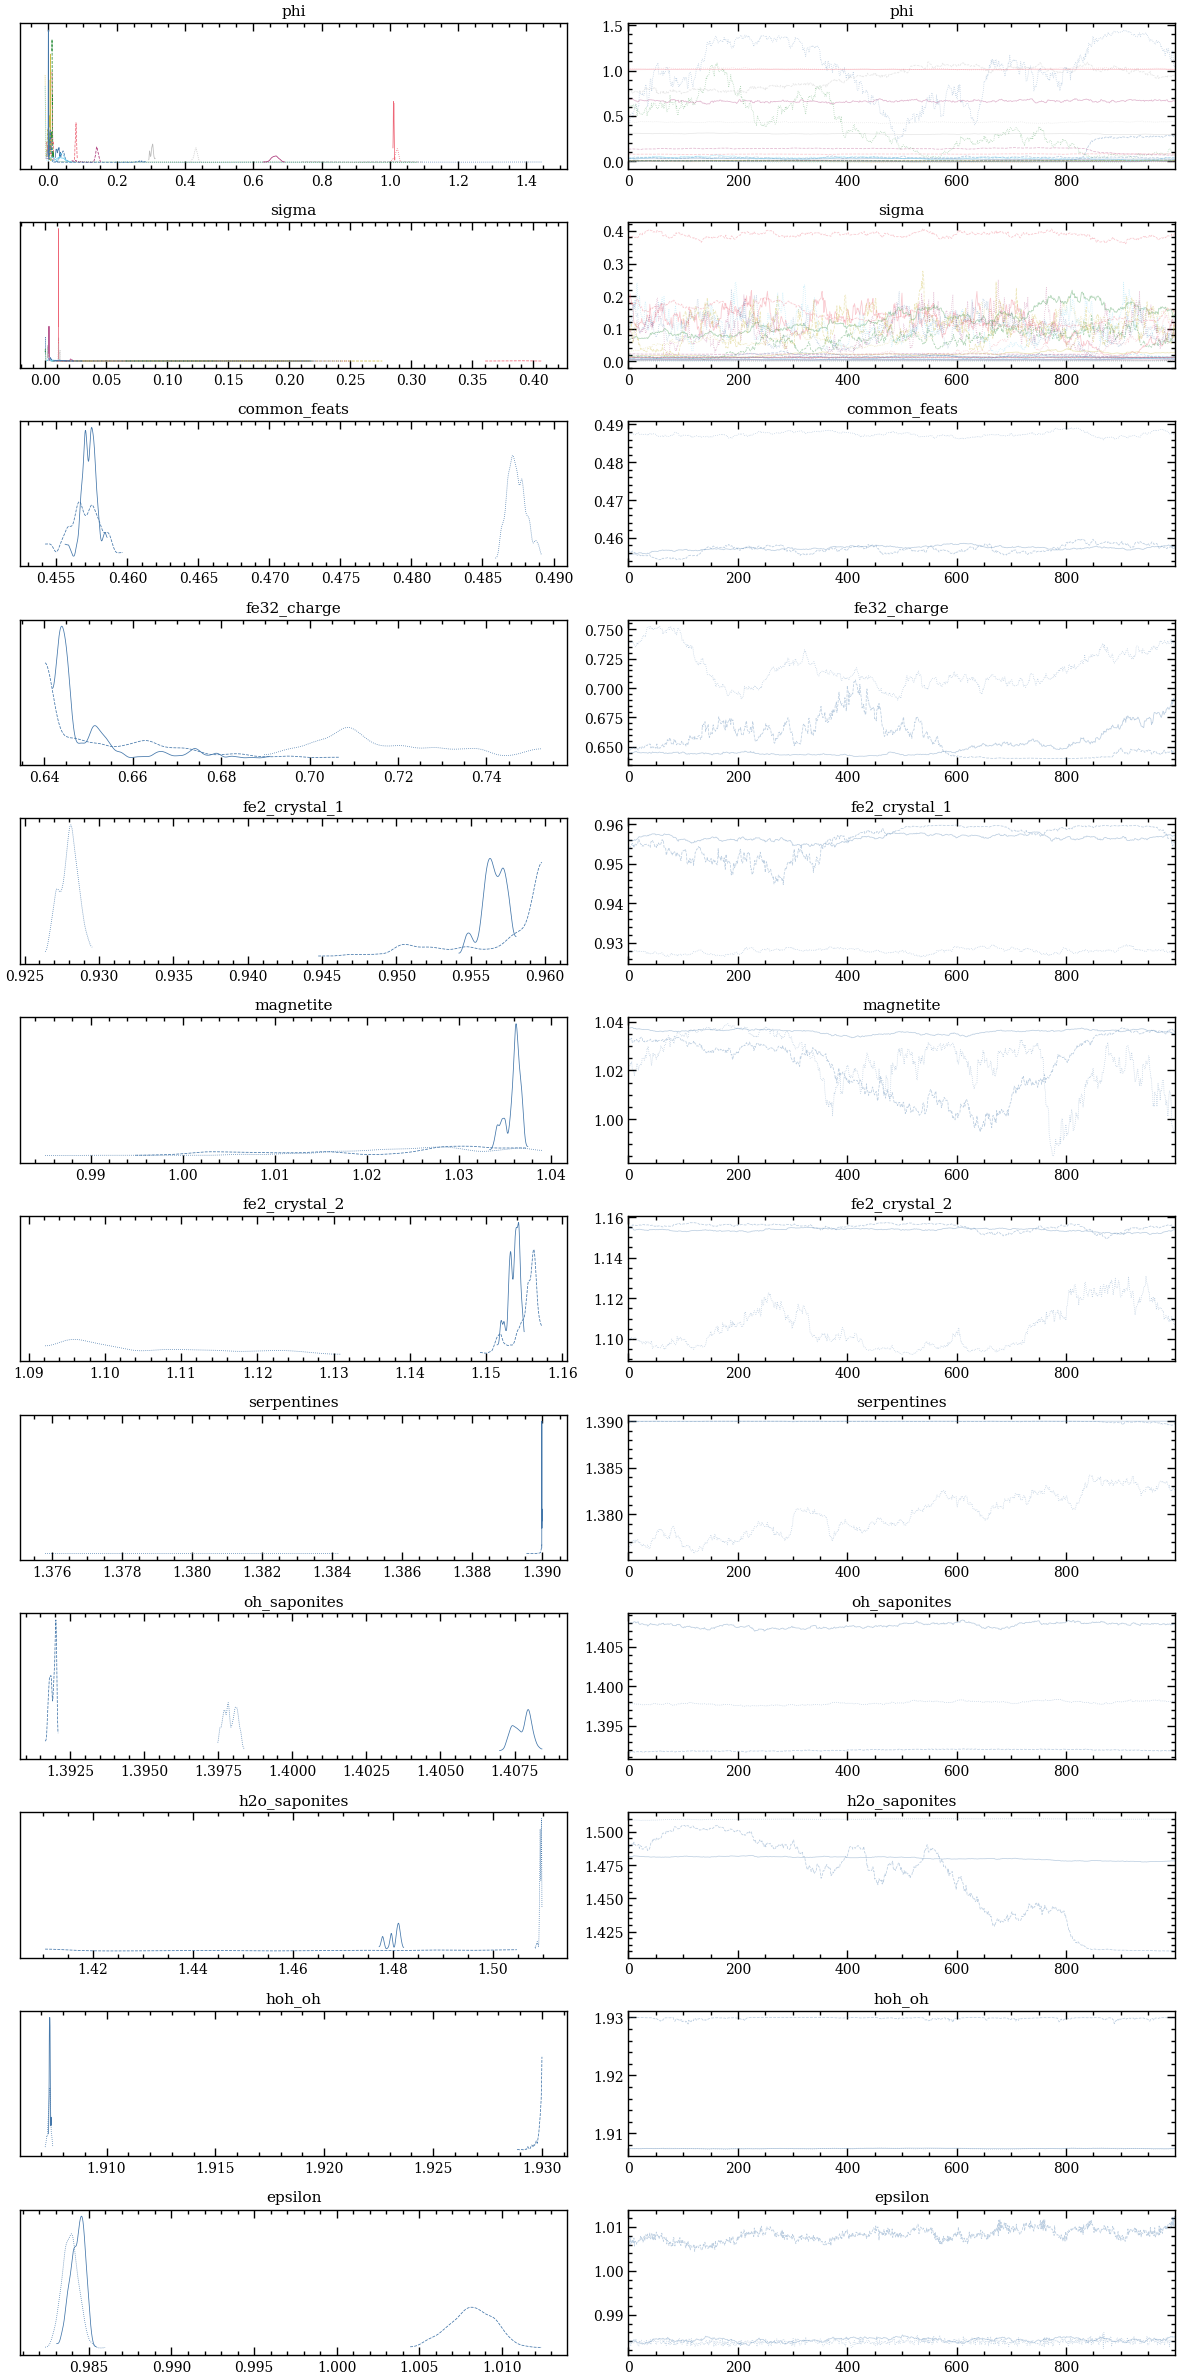

In [21]:
# means

ax = az.plot_trace(draws, var_names = ['phi', 'sigma', 'common_feats',
                                       'fe32_charge',
                                       'fe2_crystal_1',
                                       'magnetite',
                                       'fe2_crystal_2',
                                       'serpentines',
                                       'oh_saponites',
                                       'h2o_saponites',
                                       'hoh_oh', 
                                      'epsilon'])



plt.tight_layout()

plt.show()

<a id = 'tau'></a>

#### Autocorrelation time

[Index](#top)

/home/heigerma/.local/lib/python3.8/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (57) in plot_autocorr, generating only 40 plots
  warnings.warn(


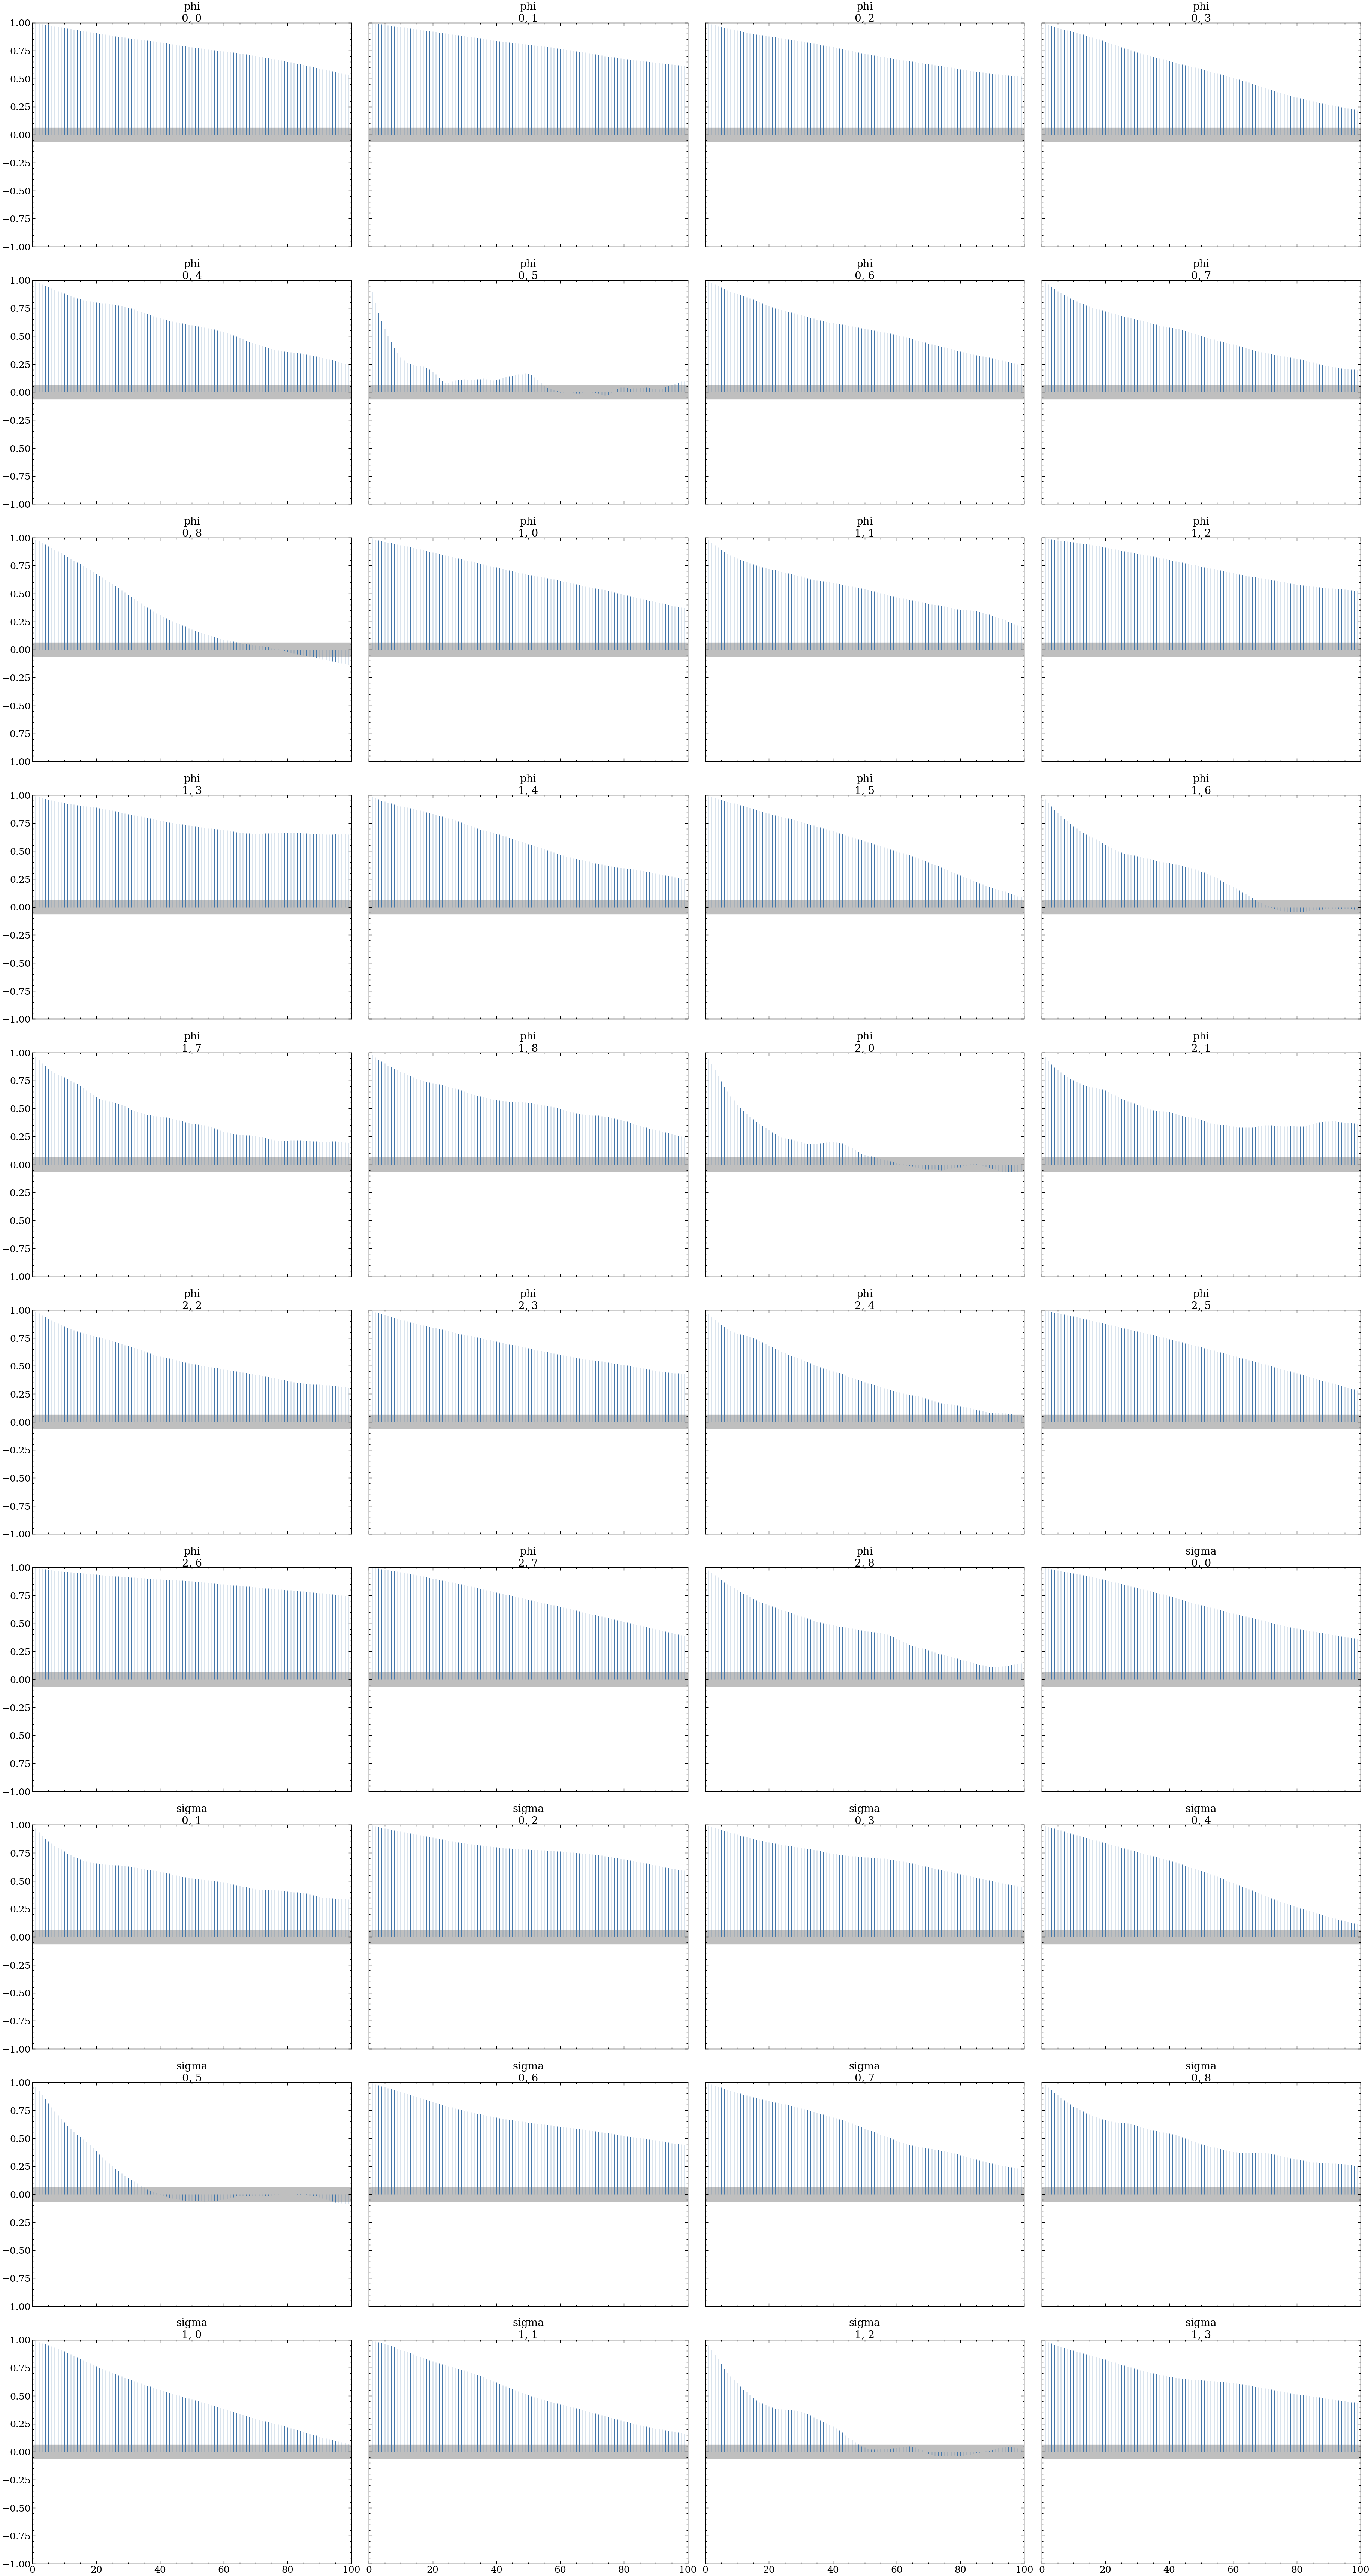

In [22]:
az.plot_autocorr(draws, var_names = ['phi', 'sigma', 'epsilon'] )

plt.tight_layout()
plt.show()

<a id = 'ess'></a>

#### Effective sample size

[Index](#top)

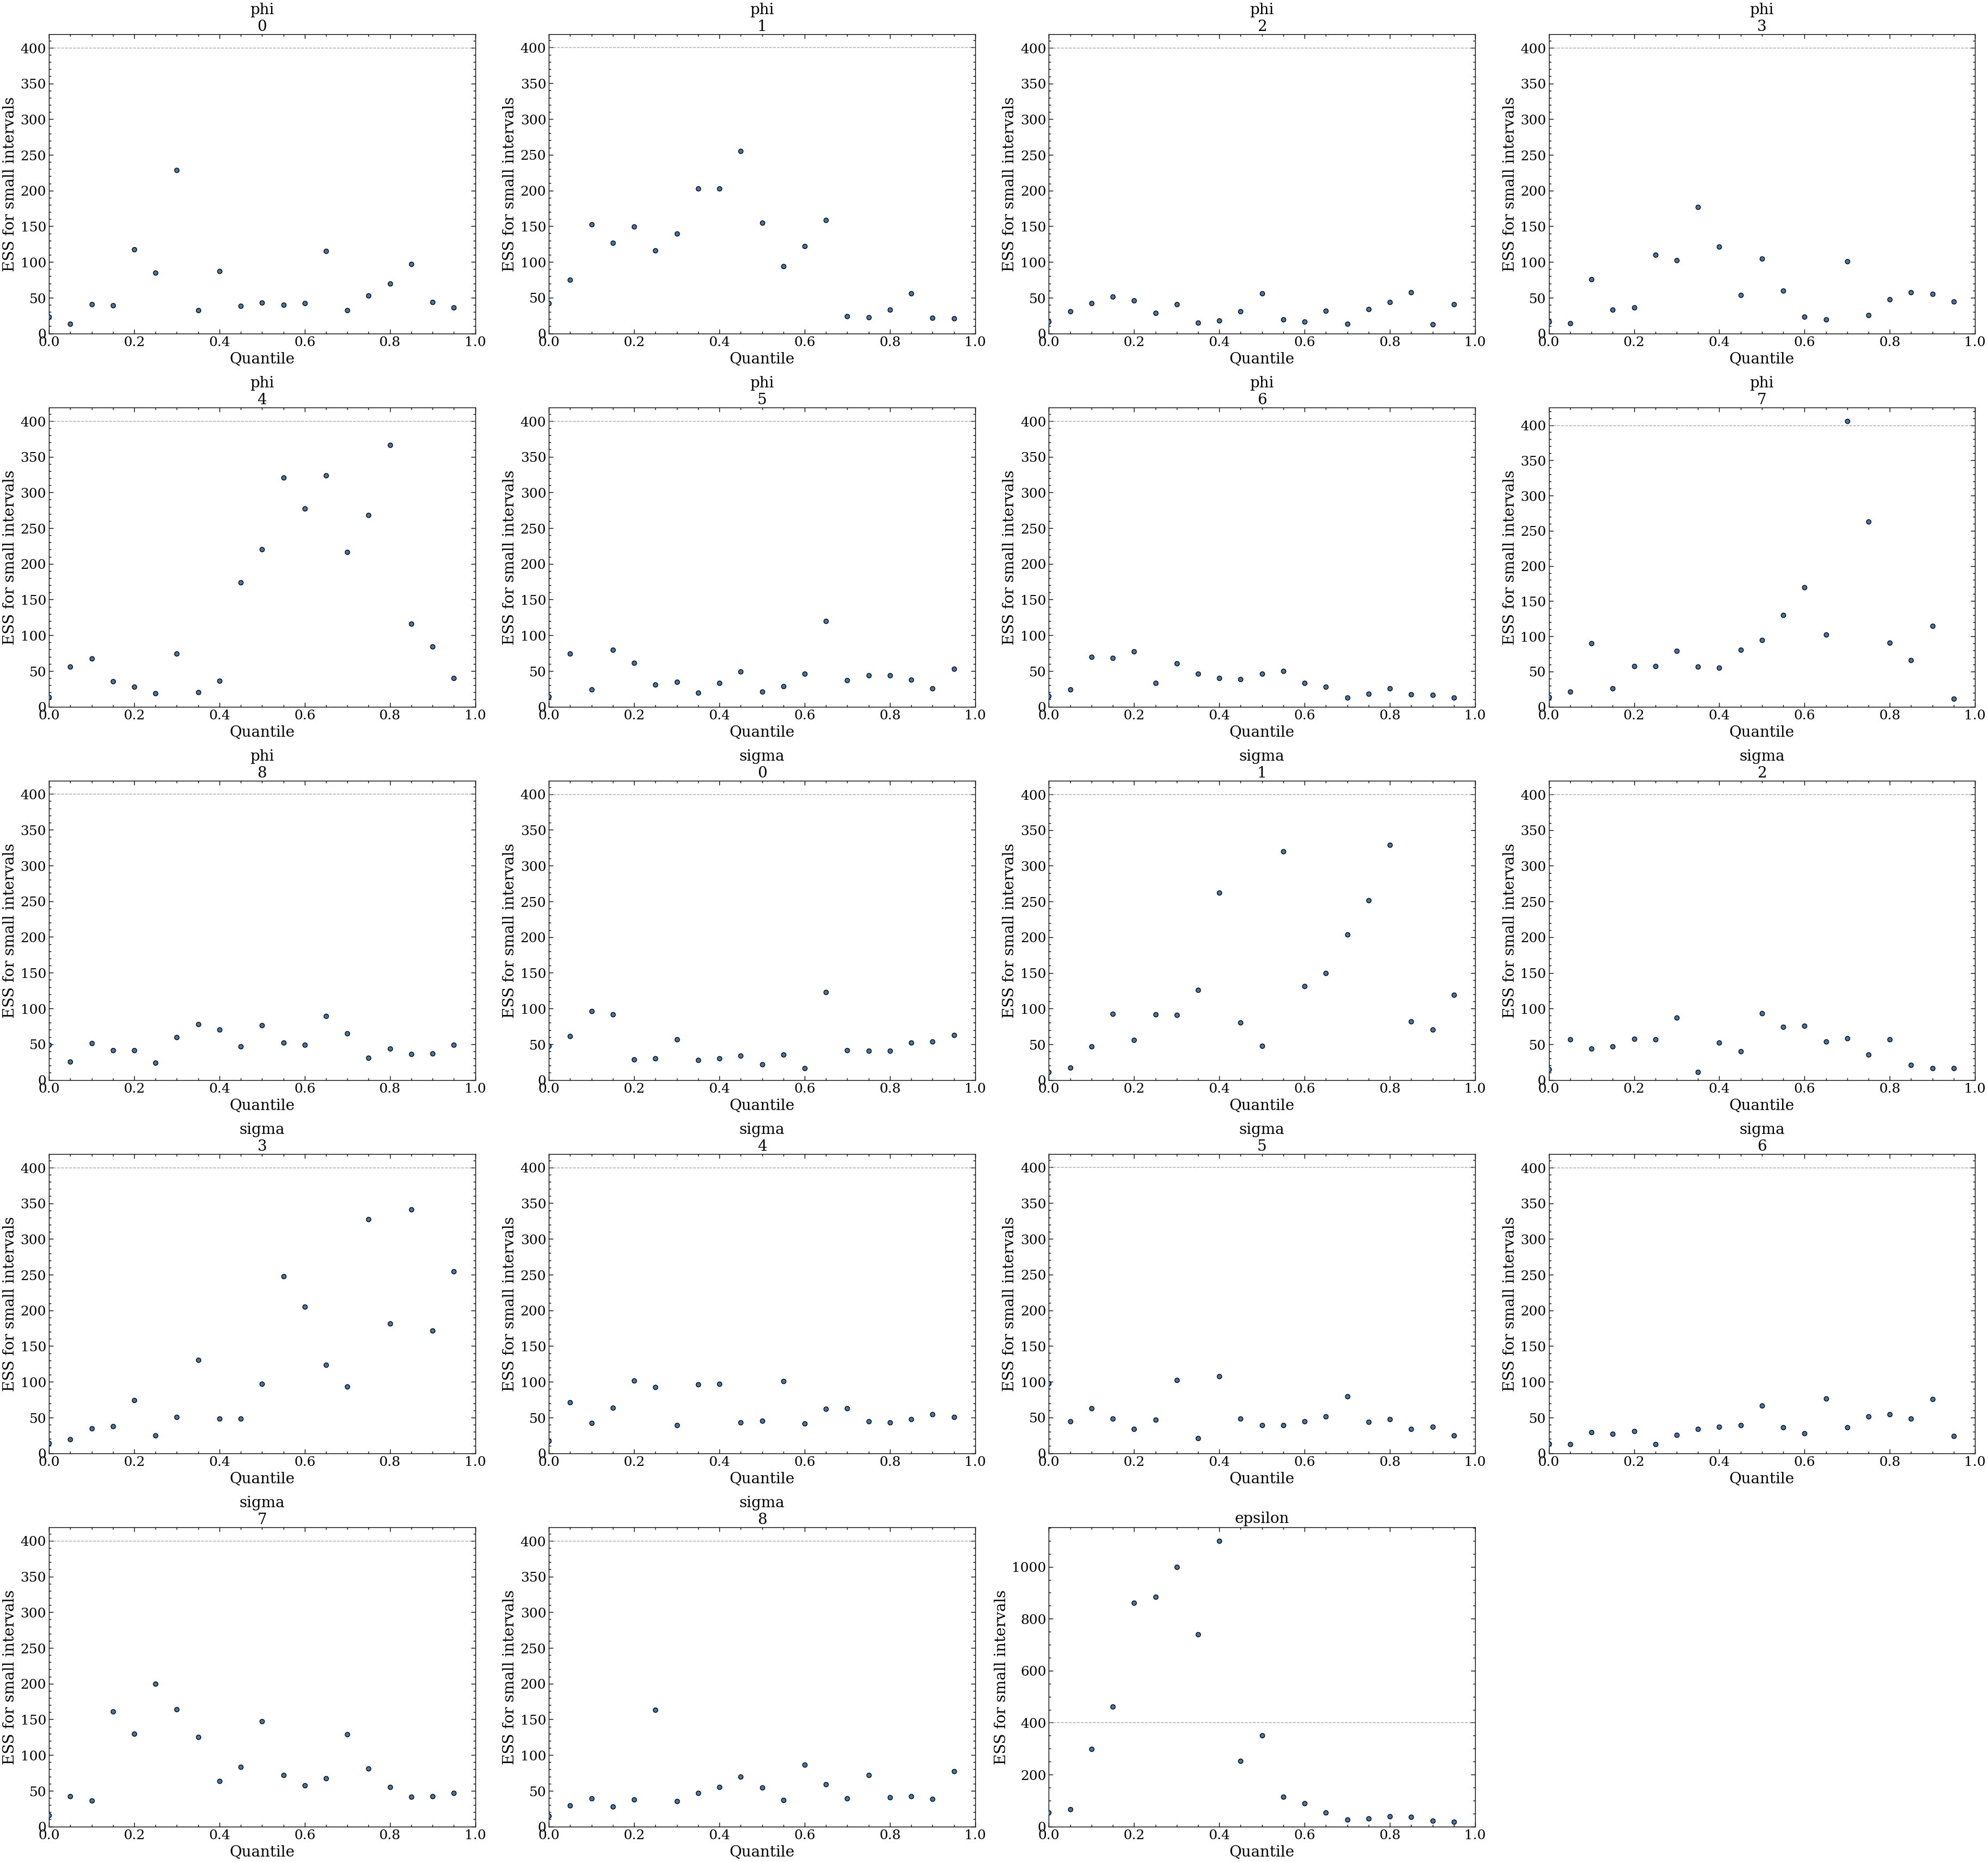

In [23]:
az.plot_ess(draws, var_names = ['phi', 'sigma', 'epsilon'])

plt.tight_layout()
plt.show()

<a id = 'corner'></a>

#### Corner plot

[Index](#top)

/home/heigerma/.local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


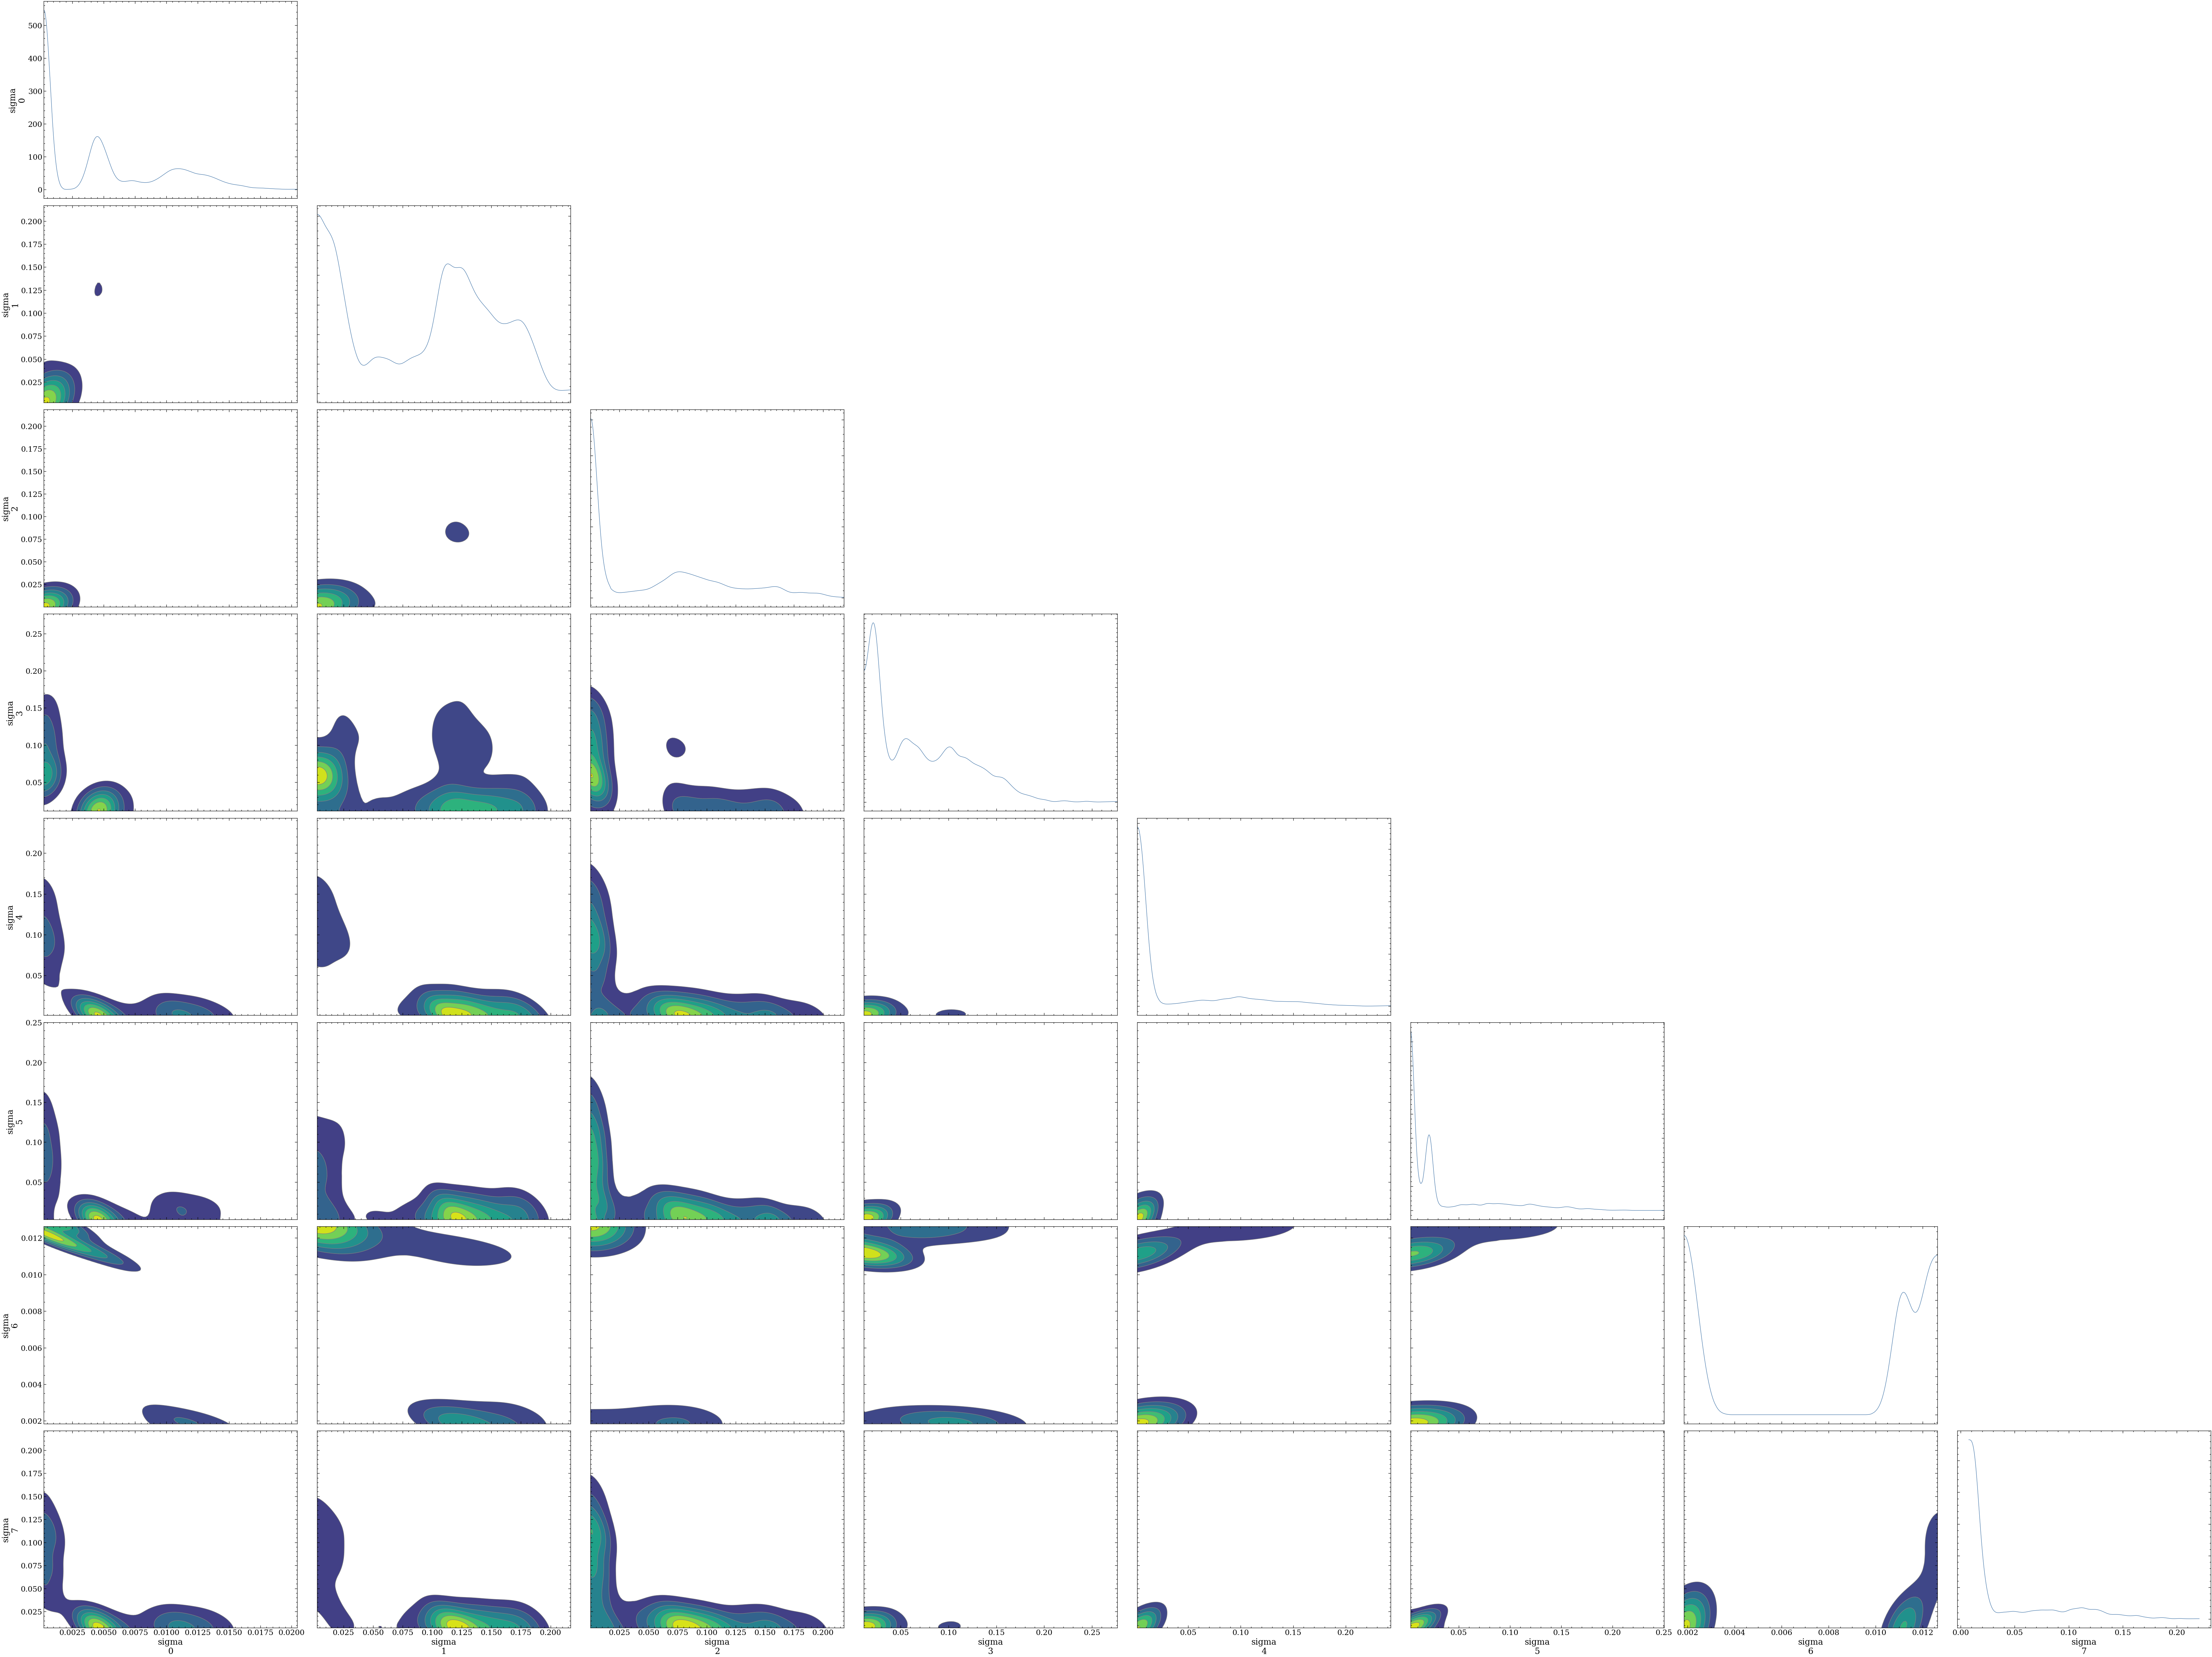

In [24]:
az.plot_pair(draws, kind = 'kde', marginals = True, var_names = ['sigma'])

plt.tight_layout()
plt.show()

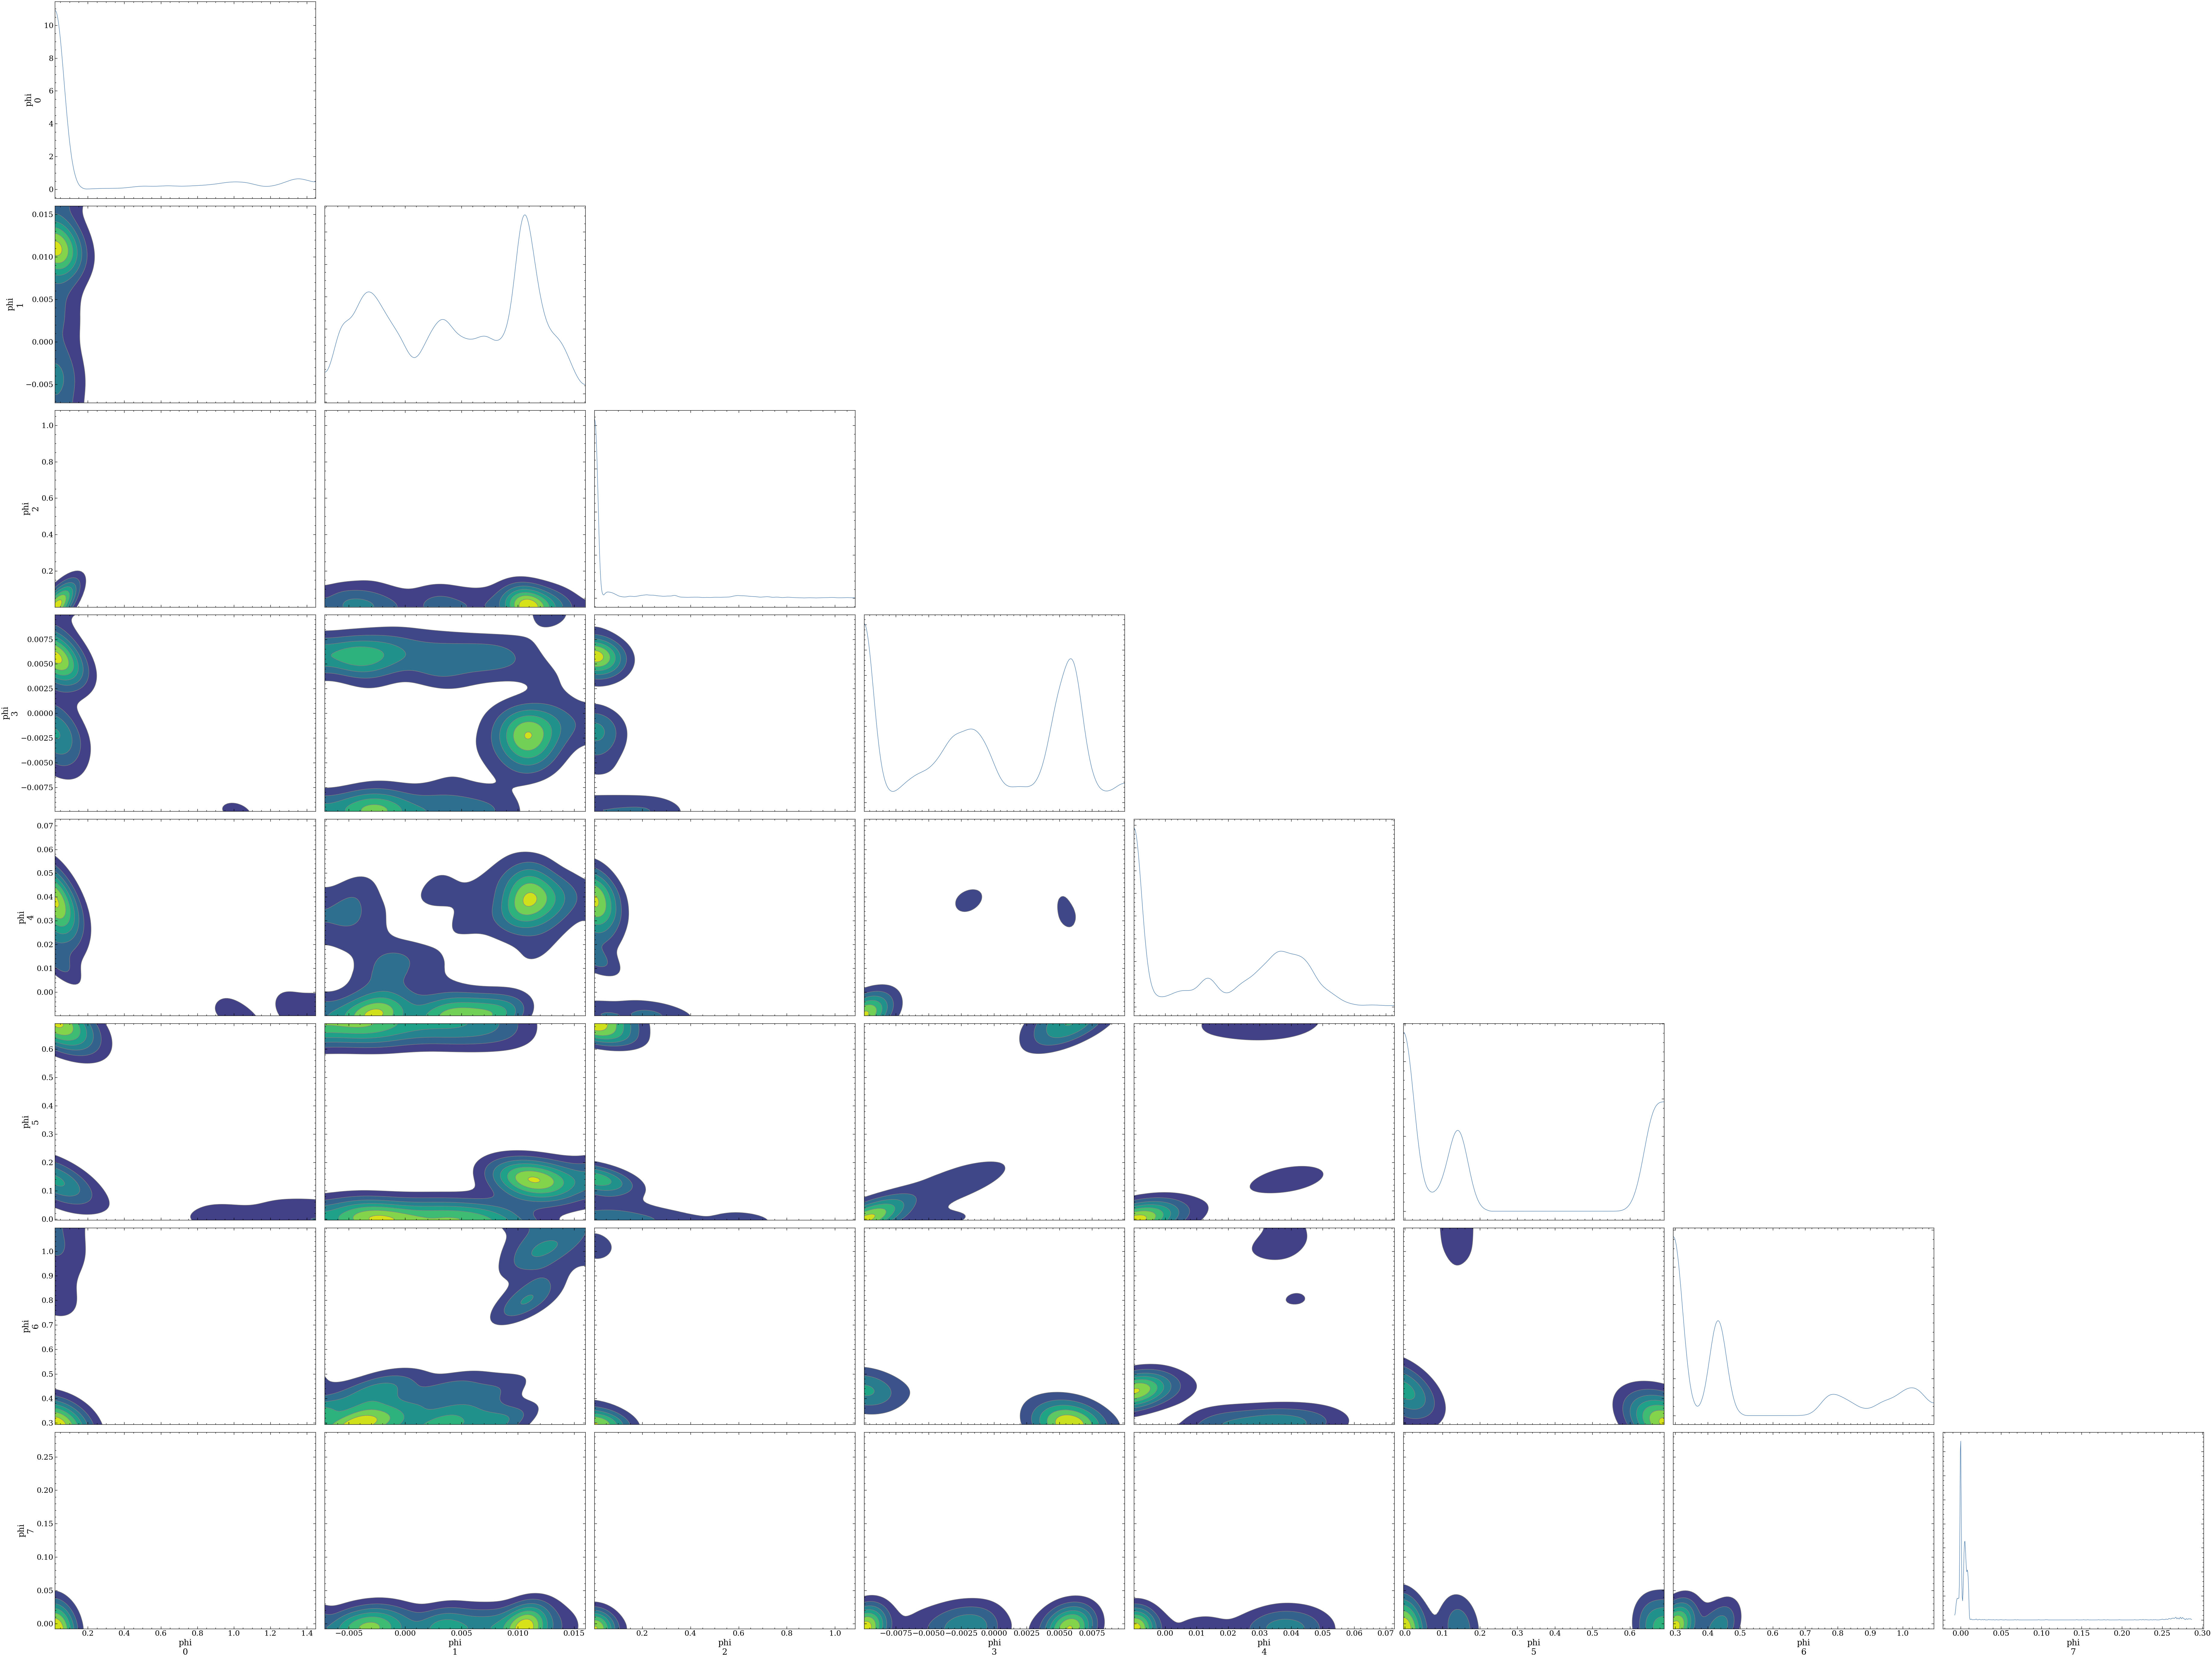

In [25]:
az.plot_pair(draws, kind = 'kde', marginals = True, var_names = ['phi'])

plt.tight_layout()
plt.show()

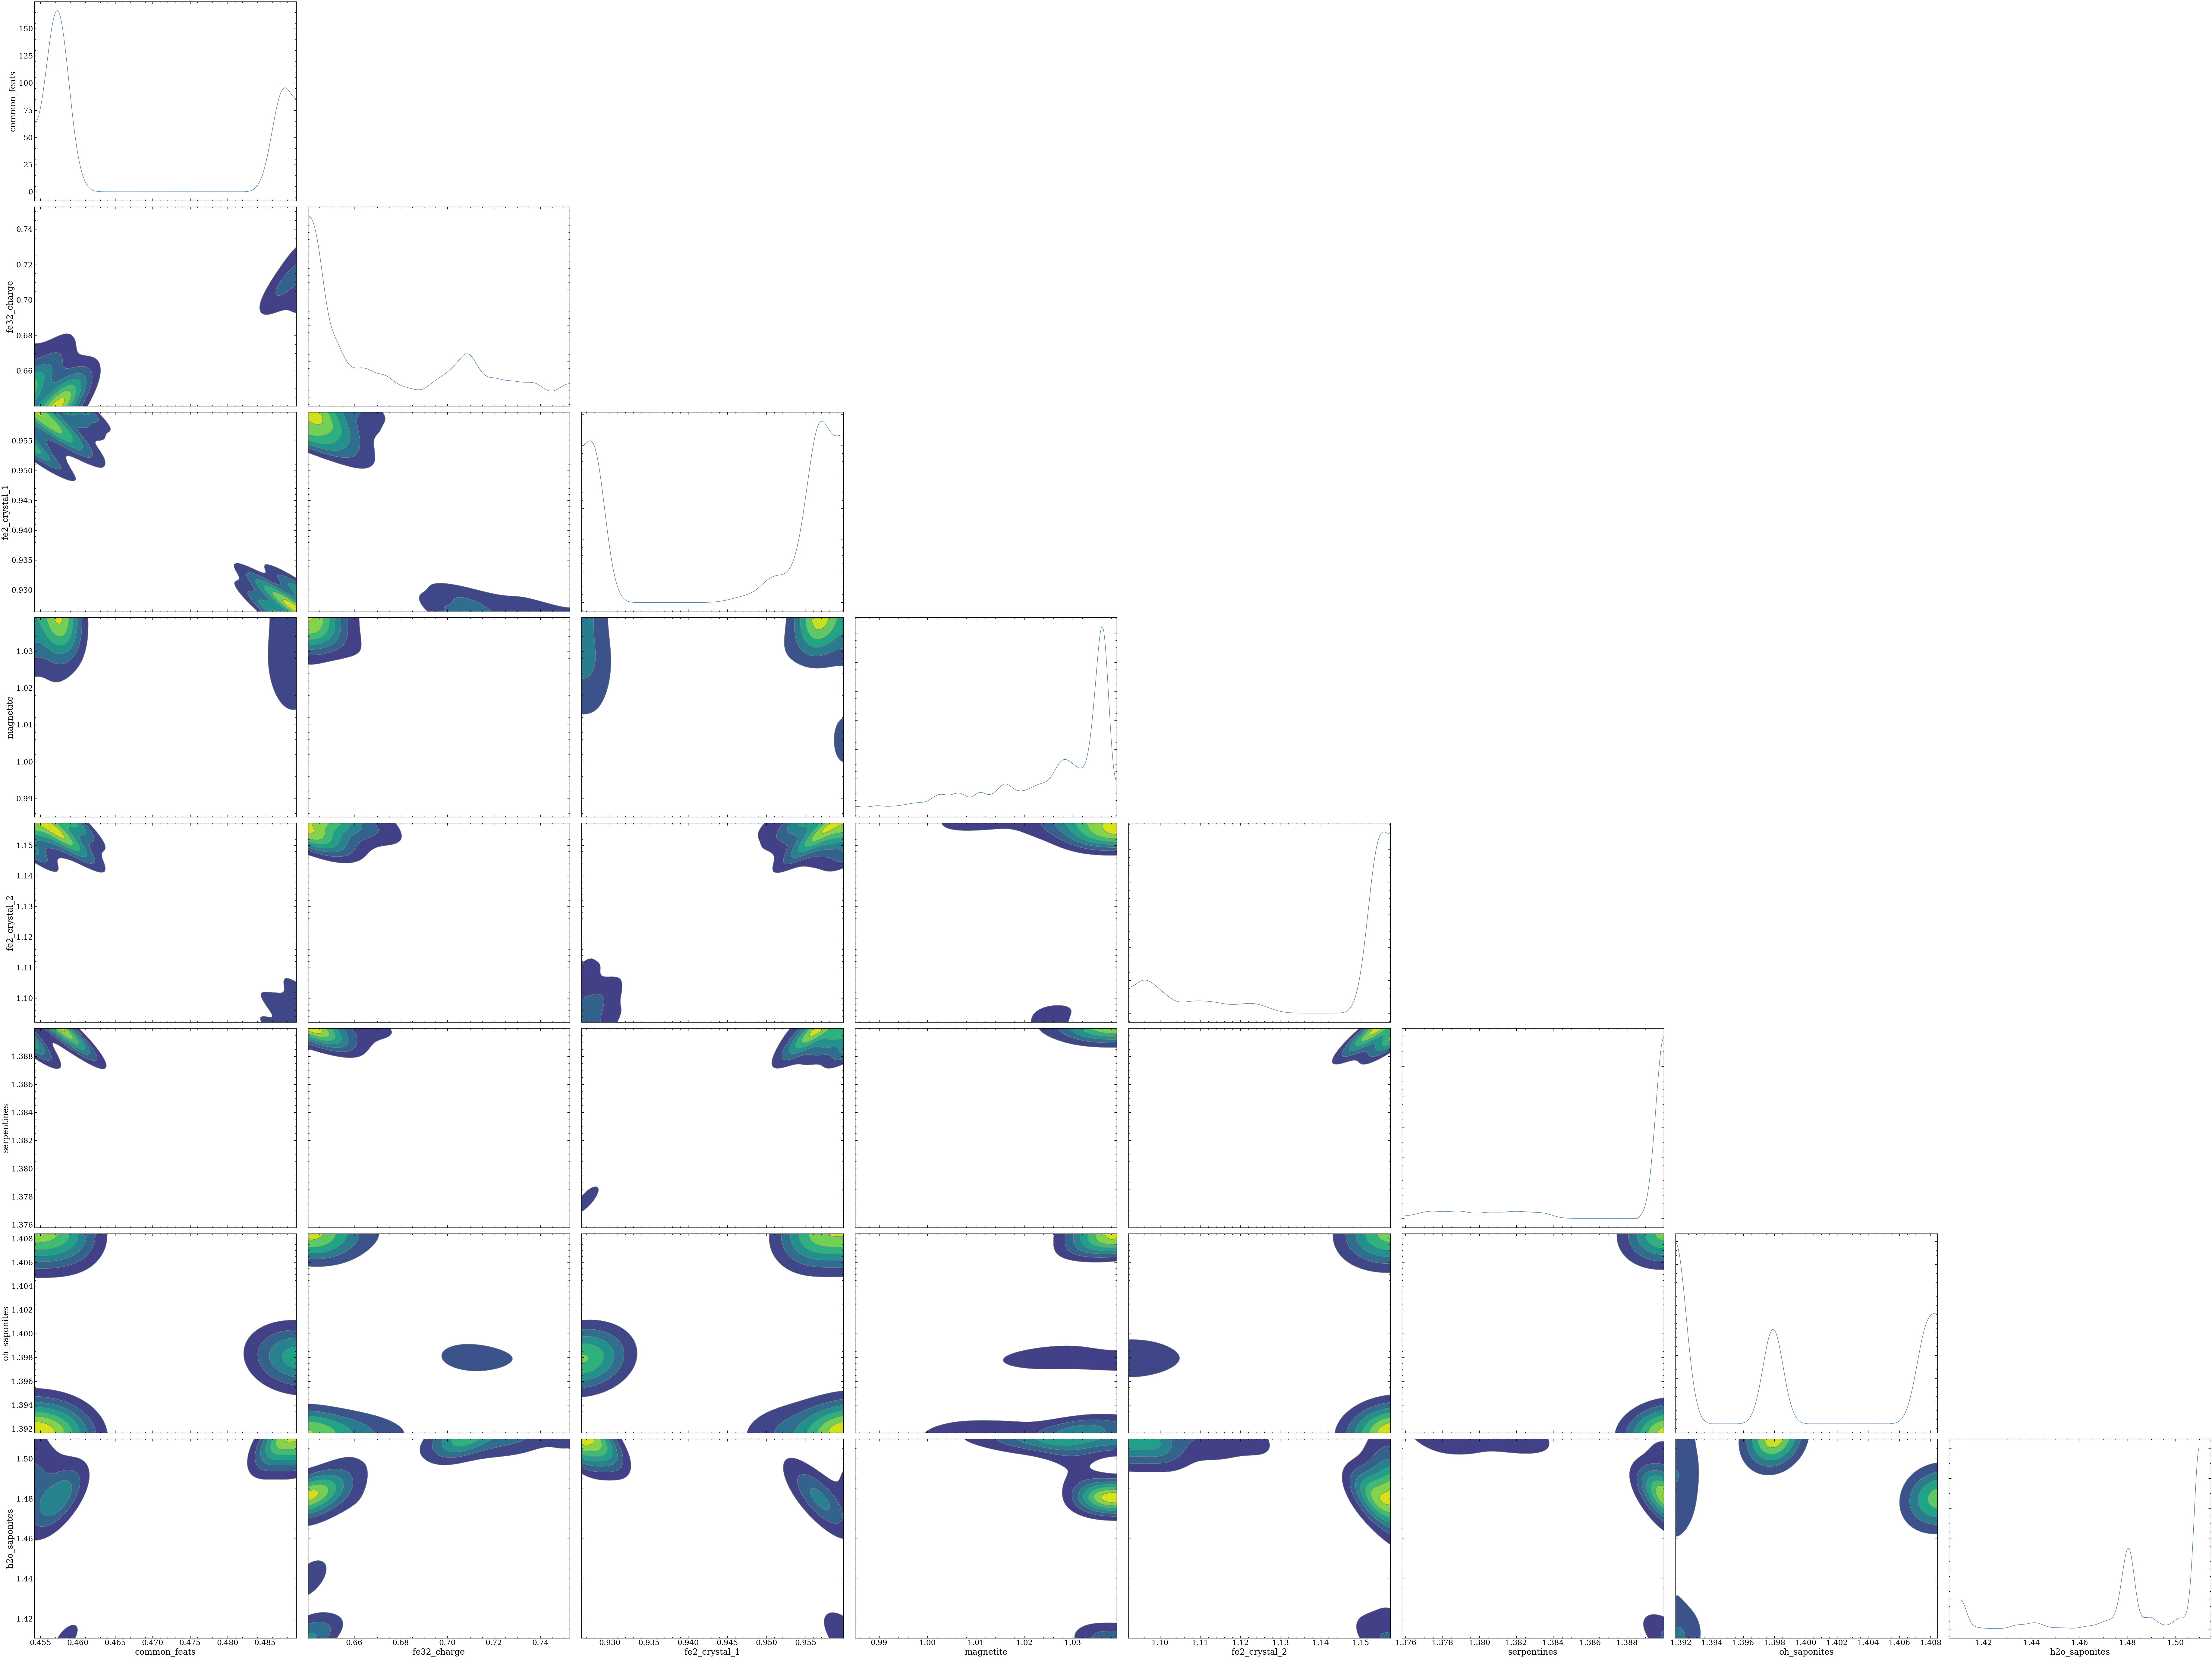

In [26]:
az.plot_pair(draws, kind = 'kde', marginals = True, var_names = ['common_feats',
                                       'fe32_charge',
                                       'fe2_crystal_1',
                                       'magnetite',
                                       'fe2_crystal_2',
                                       'serpentines',
                                       'oh_saponites',
                                       'h2o_saponites',
                                       'hoh_oh'])

plt.tight_layout()
plt.show()

<a id = 'energy'></a>

#### Energy plot

These should look basically the same. If their shapes are really different then something is wrong.

It looks much more normal when we have longer chains and longer burn-in than the 1000 + 1000 here.


[Index](#top)

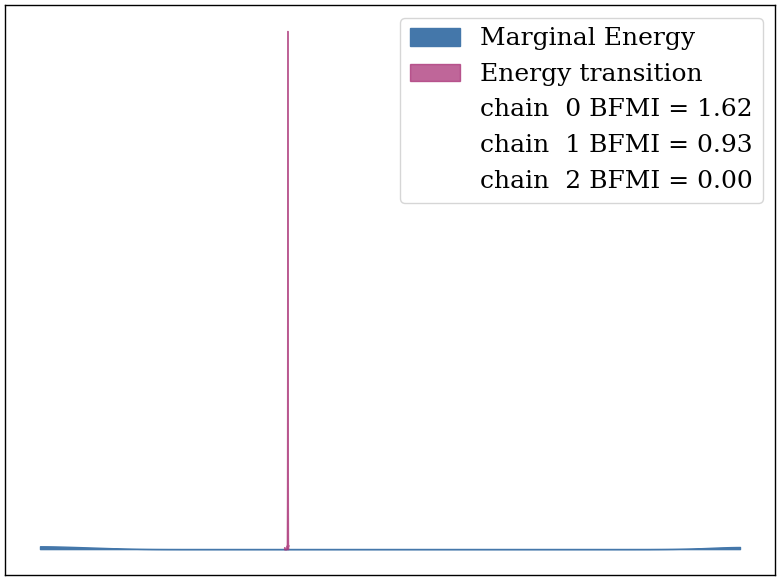

In [27]:
az.plot_energy(draws)

plt.show()